# EDA

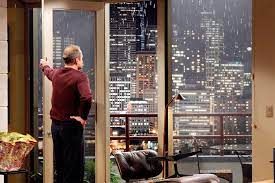

In [4]:
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno


from matplotlib.ticker import PercentFormatter
plt.rcParams.update({ "figure.figsize" : (8, 5),"axes.facecolor" : "white", "axes.edgecolor":  "black"})
plt.rcParams["figure.facecolor"]= "w"
pd.plotting.register_matplotlib_converters()
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [5]:
# to be updated!
# -- main.py

# -- to be updated! create separate file ccleaning.py

#import pandas as pd  # only if you need it

#def clean_data(df):
    # put ALL your existing cleaning code in here
    # example:
#    df = df.dropna()
#    df = df.rename(columns={"old_name": "new_name"})
    # more cleaning steps...
#    return df


# -- to be updated! from cleaning import clean_data  # import from cleaning.py

#def main():
#    df = pd.read_csv('data/eda_project.csv')
#    df_clean = clean_data(df)    # call your cleaning function
#    print(df_clean.head())

#if __name__ == "__main__":
#    main()



df = pd.read_csv('data/eda_project.csv')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   bedrooms       21597 non-null  float64
 2   bathrooms      21597 non-null  float64
 3   sqft_living    21597 non-null  float64
 4   sqft_lot       21597 non-null  float64
 5   floors         21597 non-null  float64
 6   waterfront     19206 non-null  float64
 7   view           21534 non-null  float64
 8   condition      21597 non-null  int64  
 9   grade          21597 non-null  int64  
 10  sqft_above     21597 non-null  float64
 11  sqft_basement  21145 non-null  float64
 12  yr_built       21597 non-null  int64  
 13  yr_renovated   17749 non-null  float64
 14  zipcode        21597 non-null  int64  
 15  lat            21597 non-null  float64
 16  long           21597 non-null  float64
 17  sqft_living15  21597 non-null  float64
 18  sqft_l

In [6]:
#cleaning data

# -- set default decimals to 2
pd.options.display.float_format = '{:.2f}'.format 

# -- set datetime type 
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')


# -- clean values for yr_renovated NaN -> 0

# replace NaN with 0 and turn into dtype int. If not renovated: 0
df['yr_renovated'] = (
    pd.to_numeric(df['yr_renovated'], errors='coerce')  # convert invalid → NaN
      .fillna(0)                                        # replace NaN / inf
      .astype(int)                                     # convert to int
)

#divide by 10, ONE TIME ('19910' -> '1991')
#df['yr_renovated'] = (df['yr_renovated']/10)


# -- clean values for waterfront NaN -> 0
df['waterfront'] = (
    pd.to_numeric(df['waterfront'], errors='coerce')  # convert invalid → NaN
      .fillna(0)                                        # replace NaN / inf
      .astype(int)                                     # convert to int
)

# -- convert to int
df['bedrooms'] = df['bedrooms'].astype(int)





In [32]:
# create columns, definitions, etc needed to test hypotheses 1-3



# -- create column: True if ever a renovation was undertaken
df['status_renovated'] = (df['yr_renovated'] > 0)

# -- create columns: price/sqft_living & price/sqft_lot (pps = price-per-squarefootage)
df['pps_living'] = (df['price']/df['sqft_living'])
df['pps_lot'] = (df['price']/df['sqft_lot'])

# -- sort year order ascending
yr_order = sorted(df['yr_built'].unique())

# -- create bins for build year - code by CGPT
bins = list(range(1900, 2030, 10))
labels = [
    '1900s','10s','20s','30s',
    '40s','50s','60s','70s',
    '80s','90s','2000s','2010s'
]

df['yr_build_decade'] = pd.cut(
    df['yr_built'],
    bins=bins,
    labels=labels,
    right=False    
)


# -- define city vs rest of county relative to zipcode
# Some zipcodes pertain to more than one city/region. Here: city-only zipcodes defined as city
# Source: https://www.ciclt.net/sn/clt/capitolimpact/gw_ziplist.aspx

seattle_only_zip = [98101, 98102, 98103, 98104, 98105, 98106, 98107, 98109, 98111,
                98112, 98114, 98115, 98116, 98117,98118, 98119, 98121, 98122,
                98124, 98125, 98126, 98131, 98132, 98134, 98136, 98144, 98145,
                98154,98160, 98161, 98164, 98171, 98174, 98199
                ]

bellevue_only_zip = [98004, 98005, 98006, 98007, 98008, 98009, 98015
                    ]

kent_only_zip = [98030, 98031, 98032, 98035, 98042, 98064
                ]

renton_only_zip = [98055, 98056, 98057, 98058, 98059
                  ]

federalway_only_zip = [98001, 98003, 98023, 98063, 98093
                      ]


# king county without Seattle
kc_wo_seattle = [
                98001, 98002, 98003, 98004, 98005, 98006, 98007, 98008, 98009,
                98010, 98011, 98013, 98014, 98015, 98019, 98022, 98023, 98024,
                98025, 98027, 98028, 98029, 98030, 98031, 98032, 98033, 98034,
                98035, 98038, 98039, 98040, 98041, 98042, 98045, 98047, 98050,
                98051, 98052, 98053, 98054, 98055, 98056, 98057, 98058, 98059,
                98062, 98063, 98064, 98065, 98068, 98070, 98071, 98072, 98073,
                98074, 98075, 98083, 98092, 98093, 98108, 98133, 98138, 98146,
                98148, 98155, 98158, 98166, 98168, 98177, 98178, 98188, 98198,
                98224, 98288, 98077
                ]

# zipcodes of places with population < 100K
kc_wo_cities = [98002, 98010, 98011, 98013, 98014, 98019, 98022, 98024, 98025,
                98027, 98028, 98029, 98033, 98034, 98038, 98039, 98040, 98041, 
                98045, 98047, 98050, 98051, 98052, 98053, 98054, 98062, 98065, 
                98068, 98070, 98071, 98072, 98073, 98074, 98075, 98083, 98092, 
                98224, 98288
               ]

# tbd! - king county zipcodes including seattle (not used here)
kc_total_zip = [98001, 98002, 98003, 98004, 98005, 98006, 98007, 98008, 98009, 
                98010, 98011, 98013, 98014, 98015, 98019, 98022, 98023, 98024, 
                98025, 98027, 98028, 98029, 98030, 98031, 98032, 98033, 98034, 
                98035, 98038, 98039, 98040, 98041, 98042, 98045, 98047, 98050, 
                98051, 98052, 98053, 98054, 98055, 98056, 98057, 98058, 98059, 
                98062, 98063, 98064, 98065, 98068, 98070, 98071, 98072, 98073, 
                98074, 98075, 98083, 98092, 98093, 98101, 98102, 98103, 98104, 
                98105, 98106, 98107, 98108, 98109, 98111, 98112, 98114, 98115, 
                98116, 98117, 98118, 98119, 98121, 98122, 98124, 98125, 98126, 
                98131, 98132, 98133, 98134, 98136, 98138, 98144, 98145, 98146, 
                98148, 98154, 98155, 98158, 98160, 98161, 98164, 98166, 98168, 
                98171, 98174, 98177, 98178, 98188, 98198, 98199, 98224, 98288
                ]

# assign values based on zipcode lists
# nested np.where method works because zipcode lists are mutually exclusive
df['location_type'] = np.where(
    df['zipcode'].isin(seattle_only_zip),
    'Seattle',
    np.where( 
        df['zipcode'].isin(bellevue_only_zip),
        'Bellevue',
        np.where(
            df['zipcode'].isin(kent_only_zip),
            'Kent',
            np.where(
                df['zipcode'].isin(renton_only_zip),
                'Renton',
                np.where(
                    df['zipcode'].isin(federalway_only_zip),
                    'Federal Way',
                    np.where(
                        df['zipcode'].isin(kc_wo_seattle),
                        'King County without Cities',
                        'Outside King County' 
                    )
                )
            )
        )
    )
)
    
# order location_type as list
location_order = df.groupby('location_type')['pps_living'].mean().sort_values(ascending=False).index



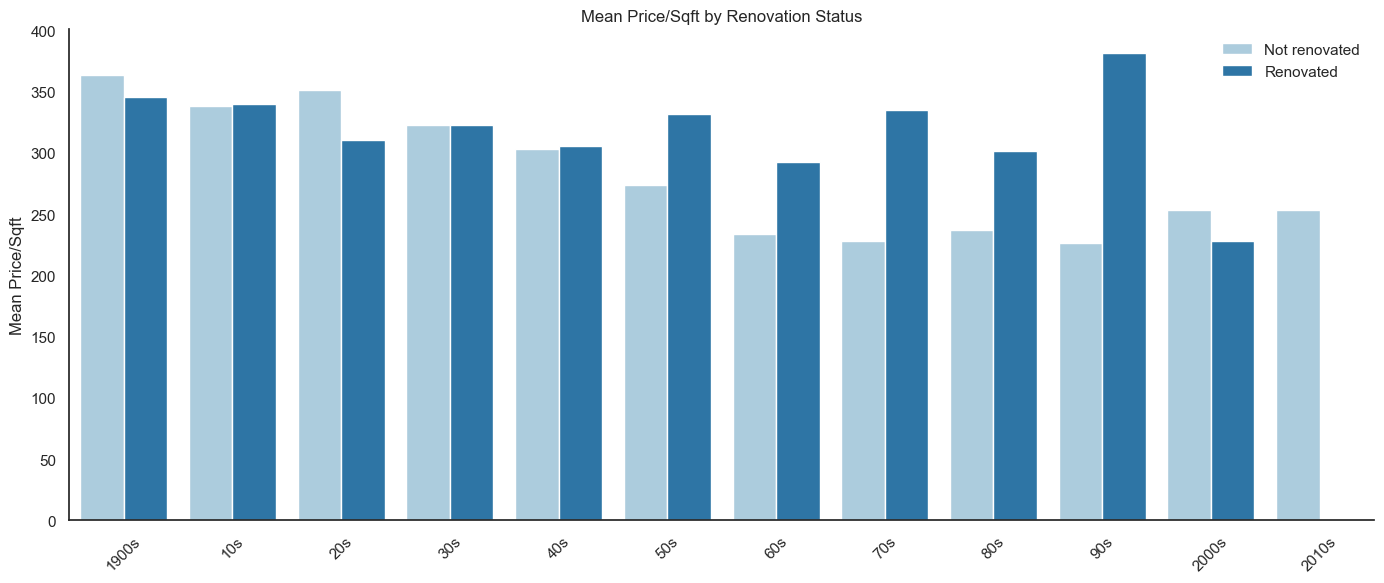

In [470]:
# Plot - Hypothesis 1
# "Renovated houses have a higher mean price/sqft than unrenovated houses built the same year."


# -- todo
# - remove errorbars
# - legend: 

# -- define final plot
plt.figure(figsize=(14, 6))

#sns.set_palette("Set2")
final_plot = sns.barplot(
    data=df,
    x='yr_build_decade',
    y='pps_living', # seaborn calculates mean
    hue='status_renovated',
    errorbar=None, #or 'sd' to show standard deviation errorbar
    #errwidth=0.5, #width of errorbar
    palette='Paired',
    saturation=0.8,
)



# -- text in plot
plt.xlabel(None)
plt.ylabel("Mean Price/Sqft")
plt.title("Mean Price/Sqft by Renovation Status")

# -- reduce ink
sns.despine()
plt.legend(labels=['Not renovated', 'Renovated'], title=None, frameon=False)

# -- print layout
plt.xticks(rotation=45) #turn labels on x-axis
plt.tight_layout()
plt.show()


In [264]:
# re Hypothesis 1
# -- high error margin 1990-1999 due to noisy sample: only 3 renovated houses in that bin.

check = (
    df[df['yr_build_decade'] == '1990–1999']
      .groupby('status_renovated')['pps_living']
      .agg(['count', 'mean', 'median', 'std', 'min', 'max'])
)
print(check)


                  count   mean  median    std    min    max
status_renovated                                           
False              2229 226.51  215.79  81.37  97.04 790.82
True                  3 381.64  313.02 291.47 130.60 701.30


In [272]:
# re Hypothesis 1
# standard deviation not shown because renovated houses = 1. 
# dataset is from 2015. It is likely that very few houses needed renovation within 15 years after construction.
check = (
    df[df['yr_build_decade'] == '2000–2009']
      .groupby('status_renovated')['pps_living']
      .agg(['count', 'mean', 'median', 'std', 'min', 'max'])
)
print(check)




                  count   mean  median   std    min    max
status_renovated                                          
False              3514 252.98  238.15 96.11  87.71 800.00
True                  1 227.90  227.90   NaN 227.90 227.90


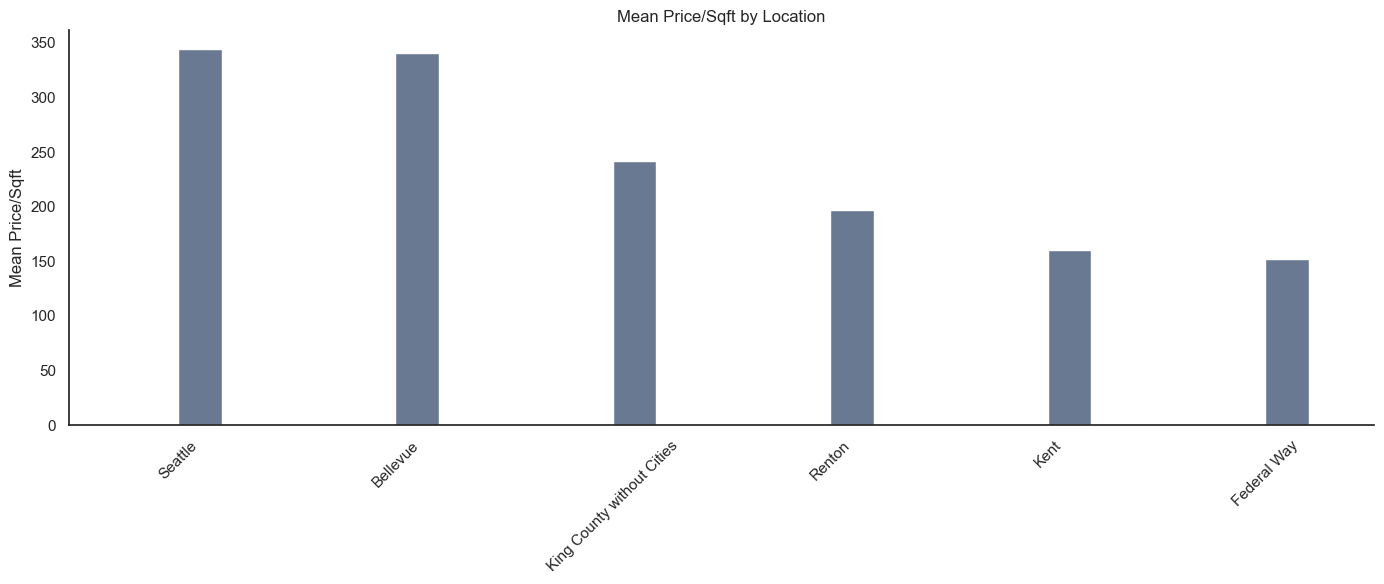

In [527]:
# plot re Hypothesis 2
# "Houses in Seattle have a higher mean price/sqft than houses in the rest of King County (by zip code)."


# -- define data final plot
plt.figure(figsize=(14, 6))

final_plot = sns.barplot(
    data=df,
    x='location_type',
    y='pps_living', # seaborn calculates mean
    order=location_order, #sorted by highest mean
    errorbar=None, #'sd' to show standard deviation errorbar
    #errwidth=0.5, #width of errorbar
    #palette='bright',
    saturation=0.4
)

# -- bar width and recenter - by cgpt
for bar in final_plot.patches:
    bar.set_width(0.2)

for bar in final_plot.patches:
    x = bar.get_x()
    w = bar.get_width()
    bar.set_x(x + (1 - w) / 2)

# -- text in plot
plt.xlabel(None)
plt.ylabel("Mean Price/Sqft")
plt.title("Mean Price/Sqft by Location")

# -- reduce ink
sns.despine()

# -- print layout
plt.xticks(rotation=45) #turn labels on x-axis
plt.tight_layout()
plt.show()





In [ ]:
# plot re Hypothesis 3
# "When square footage of living space is greater than that of the neighbors, price/sqft is higher."
# in other words H3: "My house is more expensive if my neighbors have smaller houses -> my pps is higher."


# -- key variable:
#sqft_living = sqft_living15 in 12% of data (2563 rows)
#key variable a)
df['sqft_greater'] = df['sqft_living'] > df['sqft_living15']

#key variable b)
df['sqft_diff'] = df['sqft_living']-df['sqft_living15']

#key variable c) 
df['sqft_ratio'] = df['sqft_living']/df['sqft_living15']

#sqft_count= (df['sqft_diff'] == 0).value_counts()

# hypothesis: if ratio > 1 then pps is higher with respect to ratio < 1


# -- define data final plot

plt.figure(figsize=(10, 6))

sns.lmplot(
    data=df,
    x='sqft_ratio',
    y='pps_living',
    hue='grade',
    scatter_kws={'alpha': 0.2, 's': 20},
    line_kws={'linewidth': 2}
)

plt.xlabel("House Size Ratio vs Neighbor (sqft_living / sqft_living15)")
plt.ylabel("Price per Sqft (PPS Living)")
plt.title("Relationship Between Relative House Size and Price per Sqft")

sns.despine()
plt.tight_layout()
plt.show()


    

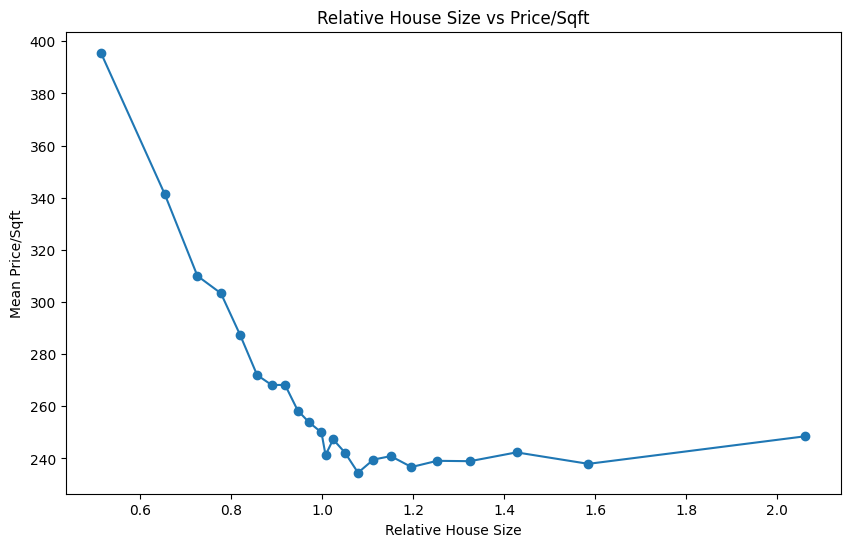

In [27]:
#bins as quantiles
df['rel_size_bin'] = pd.qcut(df['sqft_ratio'], q=25, duplicates='drop')

#get mean per bin rel_size & pps
binned = df.groupby('rel_size_bin').agg(
    mean_rel_size=('sqft_ratio', 'mean'),
    mean_pps=('pps_living', 'mean'),
    count=('pps_living', 'size')
).reset_index()

#plot
plt.figure(figsize=(10,6))

plt.plot(binned['mean_rel_size'], binned['mean_pps'], marker='o')
plt.xlabel("Relative House Size")
plt.ylabel("Mean Price/Sqft")
plt.title("Relative House Size vs Price/Sqft")
#plt.grid(True)
plt.show()


In [11]:
df[['sqft_ratio', 'pps_living']].corr()

,sqft_ratio,pps_living
sqft_ratio,1.00,-0.22
pps_living,-0.22,1.00


In [12]:
df['sqft_diff'].describe()

count   21597.00
mean       93.70
std       600.61
min     -2310.00
25%      -220.00
50%         0.00
75%       310.00
max      8690.00
Name: sqft_diff, dtype: float64

In [36]:
df

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,price,status_renovated,pps_living,pps_lot,yr_build_decade,location_type,sqft_greater,sqft_diff,sqft_ratio,rel_size_bin
0,7129300520,3,1.00,1180.00,5650.00,1.00,0,0.00,3,7,...,221900.00,False,188.05,39.27,50s,King County without Cities,False,-160.00,0.88,"(0.874, 0.904]"
1,6414100192,3,2.25,2570.00,7242.00,2.00,0,0.00,3,7,...,538000.00,True,209.34,74.29,50s,Seattle,True,880.00,1.52,"(1.489, 1.709]"
2,5631500400,2,1.00,770.00,10000.00,1.00,0,0.00,3,6,...,180000.00,False,233.77,18.00,30s,King County without Cities,False,-1950.00,0.28,"(0.186, 0.606]"
3,2487200875,4,3.00,1960.00,5000.00,1.00,0,0.00,5,7,...,604000.00,False,308.16,120.80,60s,Seattle,True,600.00,1.44,"(1.372, 1.489]"
4,1954400510,3,2.00,1680.00,8080.00,1.00,0,0.00,3,8,...,510000.00,False,303.57,63.12,80s,King County without Cities,False,-120.00,0.93,"(0.933, 0.958]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,3,2.50,1530.00,1131.00,3.00,0,0.00,3,8,...,360000.00,False,235.29,318.30,2000s,Seattle,False,0.00,1.00,"(0.984, 1.0]"
21593,6600060120,4,2.50,2310.00,5813.00,2.00,0,0.00,3,8,...,400000.00,False,173.16,68.81,2010s,King County without Cities,True,480.00,1.26,"(1.222, 1.283]"
21594,1523300141,2,0.75,1020.00,1350.00,2.00,0,0.00,3,7,...,402101.00,False,394.22,297.85,2000s,Seattle,False,0.00,1.00,"(0.984, 1.0]"
21595,291310100,3,2.50,1600.00,2388.00,2.00,0,0.00,3,8,...,400000.00,False,250.00,167.50,2000s,King County without Cities,True,190.00,1.13,"(1.13, 1.171]"
